# Load and Clean the Dataset

In [2]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_excel(r"C:\Users\Mohhit\Desktop\CSV FILE\Online Retail.xlsx")

In [4]:
# Convert InvoiceDate to datetime if not already
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [5]:
# Drop rows with missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

In [6]:
# Remove cancelled orders (usually marked with InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [7]:
# Reset index
df.reset_index(drop=True, inplace=True)

In [8]:
# Show basic info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397924 entries, 0 to 397923
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.3+ MB
None


# Market Basket Analysis (Using Apriori)

In [10]:
from mlxtend.frequent_patterns import apriori, association_rules

In [11]:
# Group by InvoiceNo and Description and sum the quantities
basket = (df[df['Country'] == "United Kingdom"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().fillna(0))

In [12]:
# Convert to 1 and 0 (presence or absence)
basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)

# Run Apriori and generate rules:

In [14]:
# Get frequent itemsets
frequent_itemsets = apriori(basket_sets, min_support=0.05, use_colnames=True)

In [15]:
# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

In [16]:
# Sort by lift
rules = rules.sort_values(by="lift", ascending=False)

In [17]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski


In [18]:
# View top rules
print(rules.head())

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []


### Machine Learning Model (Customer Segmentation using K-Means)

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [21]:
# Aggregate customer data
customer_df = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'InvoiceDate': [min, max]
})

In [22]:
customer_df.columns = ['Invoices', 'TotalQuantity', 'AvgPrice', 'FirstPurchase', 'LastPurchase']

In [23]:
# Calculate Recency (e.g., days since last purchase)
snapshot_date = df['InvoiceDate'].max()
customer_df['Recency'] = (snapshot_date - customer_df['LastPurchase']).dt.days

In [24]:
# Drop date columns and scale features
X = customer_df[['Invoices', 'TotalQuantity', 'AvgPrice', 'Recency']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means:

In [26]:
# Fit KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(X_scaled)

In [27]:
# Analyze the clusters
print(customer_df.groupby('Cluster').mean())

          Invoices  TotalQuantity     AvgPrice                 FirstPurchase  \
Cluster                                                                        
0         4.703072    1123.915607     3.572867 2011-05-19 04:30:02.959975168   
1        68.333333   51937.625000     4.008679 2010-12-15 02:54:05.000000000   
2         1.592117     286.720440     5.252147 2011-03-10 04:57:04.839596800   
3         1.000000       1.000000  2033.100000 2011-09-15 15:20:00.000000000   

                         LastPurchase     Recency  
Cluster                                            
0       2011-10-29 22:21:42.109835520   40.085945  
1       2011-11-20 15:36:17.500000000   18.500000  
2       2011-04-07 23:02:05.059578368  245.071494  
3       2011-09-15 15:20:00.000000000   84.000000  


In [28]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, customer_df['Cluster'])
print(f"Silhouette Score: {score:.3f}")


Silhouette Score: 0.583


In [29]:
print(f"Inertia: {kmeans.inertia_}")

Inertia: 6141.823950890472


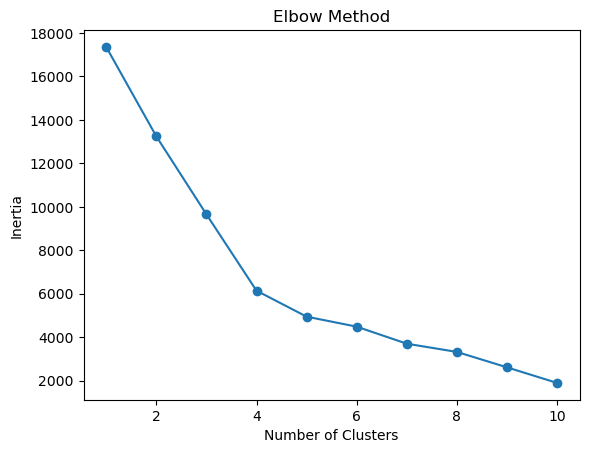

In [30]:
inertias = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertias.append(model.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [31]:
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []
